# **Preparing**

In [1]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem.Draw import IPythonConsole
from tqdm.auto import tqdm
tqdm.pandas()
from rdkit.Chem import RDConfig
import os
import sys
sascore_path = os.path.join(RDConfig.RDContribDir, 'SA_Score')
if sascore_path not in sys.path: sys.path.append(sascore_path)
import sascorer
os.chdir("./Data/")


In [2]:
smiles = [
    "CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C",
    "CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C",
    "CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O",
]
names = ["cyclosporine", "clozapine", "beta-carotene", "cannabidiol"]

name                                             smiles  \
0   cyclosporine  CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...   
1      clozapine       CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C   
2  beta-carotene  CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...   
3    cannabidiol         CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O   

                                               ROMol  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...
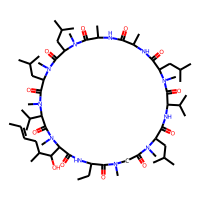
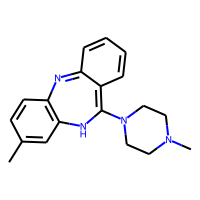
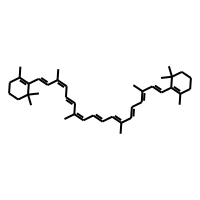
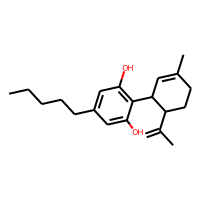

In [3]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

**Calculate descriptors**

In [4]:
def calculate_descriptors(smiles):
    """
    Calculate Ro5-relevant chemical properties.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Ro5-relevant chemical properties.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    tpsa = Descriptors.TPSA(molecule)
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, tpsa],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa"],
    )
    
# des = molecules["smiles"].progress_apply(calculate_descriptors)
# molecules = pd.concat([molecules, des], axis=1)
# des

# **Medicinal Chemistry Rules**

1. [QED](https://www.nature.com/articles/nchem.1243)
- A measure of drug-likeness based on the concept of desirability. QED is calculated by integrating the outputs of the desirability functions based on eight drug-likeness related properties, including MW, log P, NHBA, NHBD, PSA, Nrotb, the number of aromatic rings (NAr), and the number of alerts for undesirable functional groups. 
- Results interpretation: The mean QED is 0.67 for the attractive compounds, 0.49 for the unattractive compounds and 0.34 for the unattractive compounds considered too complex.

2. [SAscore](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-1-8)
- Synthetic accessibility score is designed to estimate ease of synthesis of drug-like molecules, based on a combination of fragment contributions and a complexity penalty. The score is between 1 (easy to make) and 10 (very difficult to make). The synthetic accessibility score (SAscore) is calculated as a combination of two components: \text { SAscore }=\text { fragmentScore - complexityPenalty } SAscore = fragmentScore - complexityPenalty 
- Results interpretation: high SAscore: ≥ 6, difficult to synthesize; low SAscore: < 6, easy to synthesize

3. [Fsp3](https://pubs.acs.org/doi/10.1021/jm901241e)
- Fsp3, the number of sp3 hybridized carbons/total carbon count, is used to determine the carbon saturation of molecules and characterize the complexity of the spatial structure of molecules. It has been demonstrated that the increased saturation measured by Fsp3 and the number of chiral centers in the molecule increase the clinical success rate, which might be related to the increased solubility, or the fact that the enhanced 3D features allow small molecules to occupy more target space.
- Results interpretation: Fsp3 ≥ 0.42 is considered a suitable value.

4. [Lipinski Rule](https://www.sciencedirect.com/science/article/abs/pii/S0169409X00001290?via%3Dihub)
- Content: MW≤500; logP≤5; Hacc≤10; Hdon≤5
- Results interpretation: If two properties are out of range, a poor absorption or permeability is possible, one is acceptable.

5. [Pfizer Rule](https://www.sciencedirect.com/science/article/abs/pii/S0960894X08008500?via%3Dihub)
- Content: logP > 3; TPSA < 75
- Results interpretation: Compounds with a high log P (>3) and low TPSA (< 75) are likely to be toxic.

6. [GSK Rule](https://pubs.acs.org/doi/10.1021/jm701122q)
- Content: MW ≤ 400; logP ≤ 4
- Results interpretation: Compounds satisfying the GSK rule may have a more favorable ADMET profile.

7. [Golden Triangle](https://www.sciencedirect.com/science/article/abs/pii/S0960894X09011858?via%3Dihub)
- Content: 200 ≤MW ≤50; -2 ≤ logD ≤5     (logP)
- Results interpretation: Compounds satisfying the GoldenTriangle rule may have a more favourable ADMET profile.

8. [PAINS](https://pubs.acs.org/doi/10.1021/jm901137j)
- Pan Assay Interference Compounds (PAINS) is one of the most famous frequent hitters filters, which comprises 480 substructures derived from the analysis of FHs determined by six target-based HTS assay. By application of these filters, it is easier to screen false positive hits and to flag suspicious compounds in screening databases. One of the most authoritative medicine magazines Journal of Medicinal Chemistry even requires authors to provide the screening results with the PAINS alerts of active compounds when submitting manuscripts.


9. [ADMETlab 2.0](https://admetmesh.scbdd.com/explanation/index)

# **1. Ro5**

- Content: MW≤500; logP≤5; Hacc≤10; Hdon≤5; TPSA≤140
- Results interpretation: If two properties are out of range, a poor absorption or permeability is possible, one is acceptable.
- Empirical decision: < 2 violations：excellent (green)；≥2 violations: poor (red)

In [5]:
def calculate_ro5_properties(smiles, fullfill = 4):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.
    fullfill: int
        Number of rules fullfill RO5

    Returns
    -------
    bool
        Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    tpsa = Descriptors.TPSA(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, tpsa <= 140]
    ro5_fulfilled = sum(conditions) >= fullfill
    # Return True if no more than one out of four conditions is violated
    # return pd.Series(
    #     [molecular_weight, n_hba, n_hbd, logp, tpsa, ro5_fulfilled],
    #     index=["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa", "ro5_fulfilled"],
    return ro5_fulfilled

# **2. Pfizer Rule - toxicity**

- Content: logP > 3; TPSA < 75
- Results interpretation: Compounds with a high log P (>3) and low TPSA (< 75) are likely to be toxic.

In [6]:
def calculate_pfizer_rule(smiles):
    """
    Test if input molecule (SMILES) fulfills Pfizer Rule.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    bool
        Pfizer Rule compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Pfizer Rule relevant chemical properties
    logp = Descriptors.MolLogP(molecule)
    tpsa = Descriptors.TPSA(molecule)
    # Check if Pfizer Rule conditions fulfilled
    conditions = [logp > 3, tpsa < 75]
    pfizer_fulfilled = sum(conditions) == 2
    # Return True if 2 conditions are both fulfilled
    return pfizer_fulfilled

# **3. GSK Rule - Favorable ADMET profile**

- Content: MW ≤ 400; logP ≤ 4
- Results interpretation: Compounds satisfying the GSK rule may have a more favorable ADMET profile.

In [7]:
def calculate_gsk_rule(smiles):
    """
    Test if input molecule (SMILES) fulfills GSK Rule.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    bool
        GSK Rule compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate GSK Rule relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if GSK Rule conditions fulfilled
    conditions = [molecular_weight <= 400, logp <= 4]
    gsk_fulfilled = sum(conditions) == 2
    # Return True if 2 conditions are fulfilled
    return gsk_fulfilled

# **4. GoldenTriangle - Favorable ADMET profile**

- Content: 200 ≤MW ≤450; -2 ≤ logD (logP) ≤5
- Results interpretation: Compounds satisfying the GoldenTriangle rule may have a more favourable ADMET profile.

In [8]:
def calculate_goldentriangle_rule(smiles):
    """
    Test if input molecule (SMILES) fulfills GoldenTriangle Rule.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    bool
        GoldenTriangle Rule compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate GoldenTriangle Rule relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if GoldenTrianlge Rule conditions fulfilled
    conditions = [200 <= molecular_weight <= 450,-2 <= logp <= 5]
    goldentriangle_fulfilled = sum(conditions) == 2
    # Return True if 2 conditions are fulfilled
    return goldentriangle_fulfilled

# **5. QED**

- A measure of drug-likeness based on the concept of desirability. QED is calculated by integrating the outputs of the desirability functions based on eight drug-likeness related properties, including MW, log P, NHBA, NHBD, PSA, Nrotb, the number of aromatic rings (NAr), and the number of alerts for undesirable functional groups. 
- Results interpretation: The mean QED is 0.67 for the attractive compounds, 0.49 for the unattractive compounds and 0.34 for the unattractive compounds considered too complex.
- Empirical decision: > 0.67: excellent (green); ≤ 0.67: poor (red)

In [9]:
def calculate_qed(smiles):
    """
    Calculate QED and test if input molecule (SMILES) is 'attractive'.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [numpy.float64, bool]
        [QED, QED_excellent]
        QED for input molecule and 'attractive'-ness.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate QED of input molecule
    qed = Chem.QED.qed(molecule)
    # Check if QED conditions fulfilled
    qed_excellent = qed > 0.67
    # Return True if condition is fulfilled
    return [qed, qed_excellent]

# **6. SAscore - - Synthetic accessibility score**

- Synthetic accessibility score is designed to estimate ease of synthesis of drug-like molecules, based on a combination of fragment contributions and a complexity penalty. The score is between 1 (easy to make) and 10 (very difficult to make). The synthetic accessibility score (SAscore) is calculated as a combination of two components: SAscore = fragmentScore - complexityPenalty 
- Results interpretation: high SAscore: ≥ 6, difficult to synthesize; low SAscore: < 6, easy to synthesize
- Empirical decision: ≤ 6：excellent (green); > 6: poor (red)

In [10]:
def calculate_sascore(smiles):
    """
    Calculate sascore and test if input molecule (SMILES) is easy to synthesize.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [numpy.float64, bool]
        [SAscore, SAscore_excellent]
        SAscore for input molecule and synthetic accessibility.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate SAscore of input molecule
    SAscore = sascorer.calculateScore(molecule)
    # Check if SAscore condition is fulfilled
    SAscore_excellent = SAscore <= 6
    # Return True if condition is fulfilled
    return [SAscore, SAscore_excellent]

# **7. Fsp3 - Fraction sp3**

- Fsp3, the number of sp3 hybridized carbons/total carbon count, is used to determine the carbon saturation of molecules and characterize the complexity of the spatial structure of molecules. It has been demonstrated that the increased saturation measured by Fsp3 and the number of chiral centers in the molecule increase the clinical success rate, which might be related to the increased solubility, or the fact that the enhanced 3D features allow small molecules to occupy more target space.
- Results interpretation: Fsp3 ≥ 0.42 is considered a suitable value.
- Empirical decision: ≥ 0.42：excellent (green); ＜0.42: poor (red)

In [11]:
def calculate_fsp3(smiles):
    """
    Calculate Fsp3 and test if input molecule (SMILES) has suitable Fsp3 value.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [float, bool]
        [fsp3, fsp3_excellent]
        Fsp3 for input molecule and its suitability.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Fsp3 of input molecule
    fsp3 = Chem.Lipinski.FractionCSP3(molecule)
    # Check if Fsp3 condition is fulfilled
    fsp3_excellent = fsp3 >= 0.42
    # Return True if condition is fulfilled
    return [fsp3, fsp3_excellent]

# **8. PAINS - Pan Assay Interference Compounds**

- Pan Assay Interference Compounds (PAINS) is one of the most famous frequent hitters filters, which comprises 480 substructures derived from the analysis of FHs determined by six target-based HTS assay. By application of these filters, it is easier to screen false positive hits and to flag suspicious compounds in screening databases. One of the most authoritative medicine magazines Journal of Medicinal Chemistry even requires authors to provide the screening results with the PAINS alerts of active compounds when submitting manuscripts.button.

In [25]:
def pains_filter(list_of_smiles):
    """
    PAINS filter for a list of SMILES.

    Parameters
    ----------
    list_of_smiles : list of str
        List of SMILES for a molecule.

    Returns
    -------
    [pd.DataFrame, pd.DataFrame]
        [matches, unmatches]
        Matches and unmatches for PAINS.
    """
    # Initialize filter
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    catalog = FilterCatalog(params)
    
    # Initialize list
    matches = []
    unmatches = []
    
    # Check each molecule
    for smiles in tqdm(list_of_smiles, total=list_of_smiles.shape[0]):
        molecule = Chem.MolFromSmiles(smiles)
        entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
        if entry is not None:
            # store PAINS information
            matches.append(
                {
                    "smiles": smiles,
                    "pains": entry.GetDescription().capitalize(),
                }
                )
        else:
            # collect molecules without PAINS
            unmatches.append({"smiles": smiles})
    
    matches = pd.DataFrame(matches)
    unmatches = pd.DataFrame(unmatches) # keep molecules without PAINS
    
    # Print result
    print(f"Number of compounds with PAINS: {len(matches)}")
    print(f"Number of compounds without PAINS: {len(unmatches)}")
    
    return [matches, unmatches]

# **Calculate all**

In [13]:
def calculate_all(smiles, descriptors = False):
    """
    Calculate all rules WITHOUT PAINS.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.
    descriptors : bool
        Extract molecular descriptors of molecule. Default is 'False'.

    Returns
    -------
    pandas.Series
        All rules w/wo descriptors.
    """
    # Calculate all rules of molecule
    ro5_rule = calculate_ro5_properties(smiles)
    pfizer_rule = calculate_pfizer_rule(smiles)
    gsk_rule = calculate_gsk_rule(smiles)
    goldentriangle_rule = calculate_goldentriangle_rule(smiles)
    qed = calculate_qed(smiles)
    sascore = calculate_sascore(smiles)
    fsp3 = calculate_fsp3(smiles)
    
    # Calculate molecular desciptors
    if not descriptors:
        return pd.Series(
            [ro5_rule, pfizer_rule, gsk_rule, goldentriangle_rule, qed[0], qed[1], 
            sascore[0], sascore[1], fsp3[0], fsp3[1]],
            index = ["ro5_rule", "pfizer_rule", "gsk_rule", "goldentriangle_rule", "qed", "qed_excellent", 
            "sascore", "sascore_excellent", "fsp3", "fsp3_excellent"]
        )
    
    if descriptors:
        des = calculate_descriptors(smiles)
        return pd.Series(
            [des["molecular_weight"], des["n_hba"], des["n_hbd"], des["logp"], des["tpsa"],
                ro5_rule, pfizer_rule, gsk_rule, goldentriangle_rule, qed[0], qed[1], 
                sascore[0], sascore[1], fsp3[0], fsp3[1]],
            index = ["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa", 
                "ro5_rule", "pfizer_rule", "gsk_rule", "goldentriangle_rule", "qed", "qed_excellent", 
                "sascore", "sascore_excellent", "fsp3", "fsp3_excellent"]
        )

# **Test**

In [14]:
LeadLike = molecules["smiles"].progress_apply(calculate_all, descriptors = True)
molecules = pd.concat([molecules, LeadLike], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

name                                             smiles  \
0   cyclosporine  CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...   
1      clozapine       CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C   
2  beta-carotene  CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...   
3    cannabidiol         CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O   

                                               ROMol  molecular_weight  n_hba  \
0  <img data-content="rdkit/molecule" src="data:i...       1201.841368   12.0   
1  <img data-content="rdkit/molecule" src="data:i...        306.184447    4.0   
2  <img data-content="rdkit/molecule" src="data:i...        536.438202    0.0   
3  <img data-content="rdkit/molecule" src="data:i...        314.224580    2.0   

   n_hbd      logp    tpsa  ro5_rule  pfizer_rule  gsk_rule  \
0    5.0   3.26900  278.80     False        False     False   
1    1.0   1.68492   30.87      True        False      True   
2    0.0  12.60580    0.00     False         True     False   
3    2.0   5.84650   40.46      True         True     False   

   goldentriangle_rule       qed  qed_excellent   sascore  sascore_excellent  \
0                False  0.147925          False  6.877891              False   
1                 True  0.869629           True  2.525961               True   
2                False  0.243513          False  3.693087               True   
3                False  0.510775          False  3.461202               True   

       fsp3  fsp3_excellent  
0  0.790323            True  
1  0.315789           False  
2  0.450000            True  
3  0.523810            True
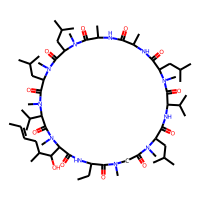
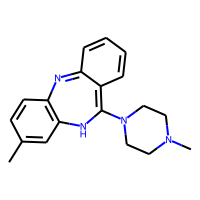
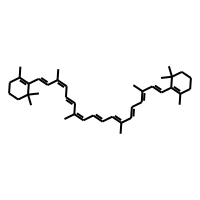
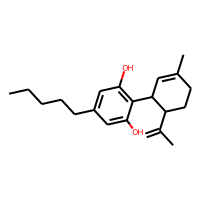

In [15]:
molecules

In [16]:
LeadLike

molecular_weight  n_hba  n_hbd      logp    tpsa  ro5_rule  pfizer_rule  \
0       1201.841368   12.0    5.0   3.26900  278.80     False        False   
1        306.184447    4.0    1.0   1.68492   30.87      True        False   
2        536.438202    0.0    0.0  12.60580    0.00     False         True   
3        314.224580    2.0    2.0   5.84650   40.46      True         True   

   gsk_rule  goldentriangle_rule       qed  qed_excellent   sascore  \
0     False                False  0.147925          False  6.877891   
1      True                 True  0.869629           True  2.525961   
2     False                False  0.243513          False  3.693087   
3     False                False  0.510775          False  3.461202   

   sascore_excellent      fsp3  fsp3_excellent  
0              False  0.790323            True  
1               True  0.315789           False  
2               True  0.450000            True  
3               True  0.523810            True

In [23]:
matches, unmatches = pains_filter(molecules["smiles"])
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(unmatches)}")

  0%|          | 0/4 [00:00<?, ?it/s]

Number of compounds with PAINS: 0
Number of compounds without PAINS: 4


In [22]:
egfr_data = pd.read_csv("EGFR_compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)

Dataframe shape: (4635, 10)


In [24]:
matches, unmatches = pains_filter(egfr_data["smiles"])

  0%|          | 0/4635 [00:00<?, ?it/s]

Number of compounds with PAINS: 408
Number of compounds without PAINS: 4227


In [ ]:
egfr_LeadLike = egfr_data